Training custom Decision Tree Regressor...
Custom Decision Tree RMSE: 2.8099
Training sklearn DecisionTreeRegressor...
Sklearn Decision Tree RMSE: 3.1751


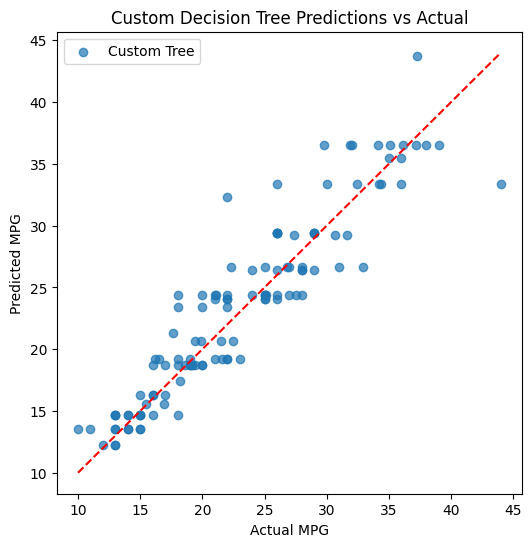

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

# -------------------------------
# Metrics
# -------------------------------
def rmse(y_pred, y_true):
    y_pred = np.array(y_pred, dtype=float)
    y_true = np.array(y_true, dtype=float)
    return np.sqrt(np.mean((y_true - y_pred) ** 2))


# -------------------------------
# Custom Decision Tree Regressor
# -------------------------------
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value  # used for leaf nodes


class DecisionTree:
    def __init__(self, max_depth=5):
        self.max_depth = max_depth
        self.root = None

    def fit(self, X, y):
        self.root = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        # stopping criteria
        if depth >= self.max_depth or len(np.unique(y)) == 1:
            return Node(value=np.mean(y))

        # find best split
        best_feat, best_thresh, best_score = None, None, float("inf")
        for feature in X.columns:
            for threshold in np.unique(X[feature]):
                left_mask = X[feature] <= threshold
                right_mask = ~left_mask
                if left_mask.sum() == 0 or right_mask.sum() == 0:
                    continue
                left_y, right_y = y[left_mask], y[right_mask]
                score = left_y.var() * len(left_y) + right_y.var() * len(right_y)
                if score < best_score:
                    best_feat, best_thresh, best_score = feature, threshold, score

        if best_feat is None:
            return Node(value=np.mean(y))

        # split data
        left_mask = X[best_feat] <= best_thresh
        right_mask = ~left_mask
        left = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        return Node(feature=best_feat, threshold=best_thresh, left=left, right=right)

    def _predict_sample(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)

    def predict(self, X):
        preds = [self._predict_sample(row, self.root) for _, row in X.iterrows()]
        return np.array(preds, dtype=float)


# -------------------------------
# Load dataset
# -------------------------------

np.random.seed(42)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
data = pd.read_csv(
    url,
    sep=r"\s+",
    header=None,
    names=["mpg", "cylinders", "displacement", "horsepower", "weight",
           "acceleration", "model year", "origin", "car name"]
)

# Clean data
data = data[data["horsepower"] != "?"]
data["horsepower"] = data["horsepower"].astype(float)
data = data.drop(columns=["car name"]).reset_index(drop=True)

# Split features and target
X = data.drop(columns=["mpg"])
y = data["mpg"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# -------------------------------
# Train custom Decision Tree
# -------------------------------
print("Training custom Decision Tree Regressor...")
my_tree = DecisionTree(max_depth=5)
my_tree.fit(X_train, y_train)
y_pred_my = my_tree.predict(X_test)
rmse_my = rmse(y_pred_my, y_test)
print(f"Custom Decision Tree RMSE: {rmse_my:.4f}")

# -------------------------------
# Train sklearn DecisionTreeRegressor
# -------------------------------
print("Training sklearn DecisionTreeRegressor...")
sk_tree = DecisionTreeRegressor(max_depth=5, random_state=42)
sk_tree.fit(X_train, y_train)
y_pred_sk = sk_tree.predict(X_test)
rmse_sk = rmse(pd.Series(y_pred_sk, index=y_test.index), y_test)
print(f"Sklearn Decision Tree RMSE: {rmse_sk:.4f}")

# -------------------------------
# Plot results
# -------------------------------
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_my, alpha=0.7, label="Custom Tree")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual MPG")
plt.ylabel("Predicted MPG")
plt.title("Custom Decision Tree Predictions vs Actual")
plt.legend()
plt.show()


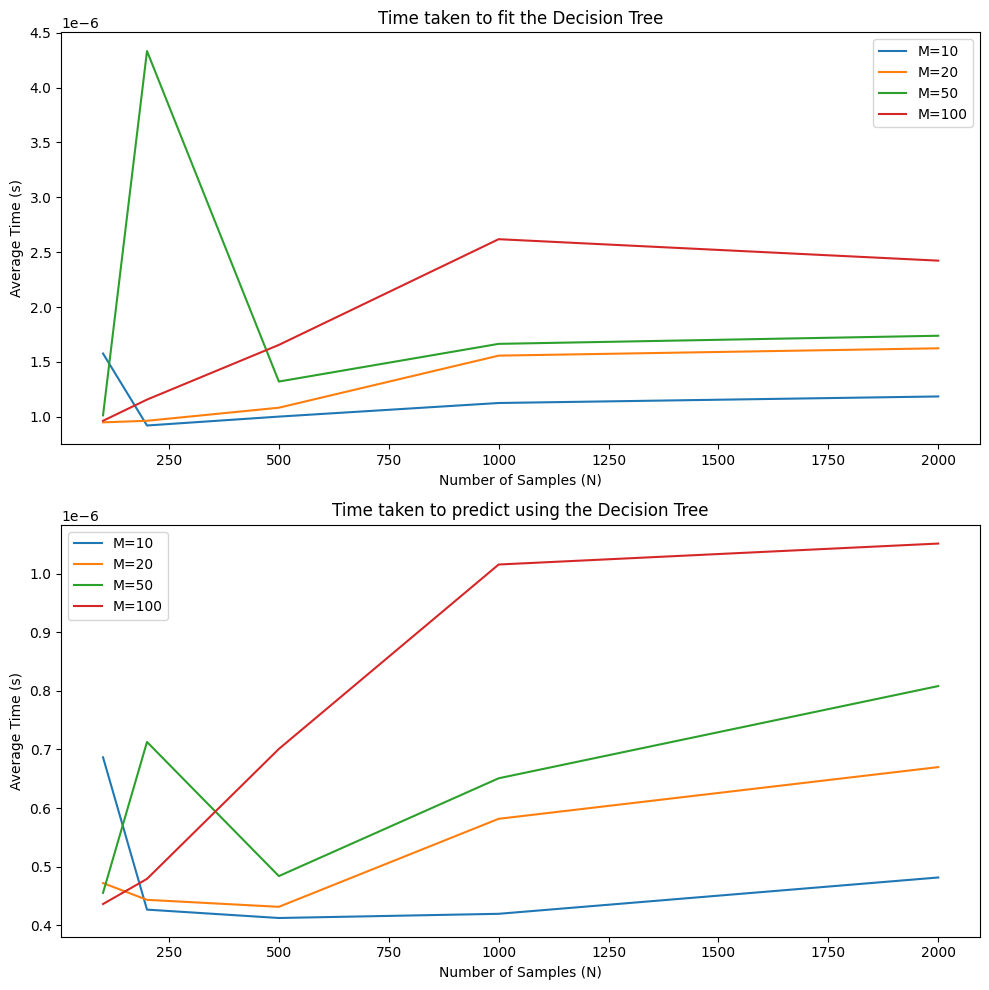

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from base import DecisionTree
from metrics import *

np.random.seed(42)
num_average_time = 100  # Number of times to run each experiment to calculate the average values

# Function to create fake data
def create_fake_data(N, M):
    X = np.random.randint(2, size=(N, M))
    y = np.random.randint(2, size=N)

    X = pd.DataFrame(X)
    y = pd.Series(y)
    return X, y

# Function to calculate average time (and std) taken by fit() and predict() for different N and M
def calculate_average_time(N_values, M_values):
    fit_times = np.zeros((len(N_values), len(M_values)))
    predict_times = np.zeros((len(N_values), len(M_values)))

    for i, N in enumerate(N_values):
        for j, M in enumerate(M_values):
            X, y = create_fake_data(N, M)
            fit_time_list = []
            predict_time_list = []

            #print(i,j)

            try:

                for _ in range(num_average_time):
                    start_time = time.time()
                    dt = DecisionTree(criterion='information_gain')
                    dt.fit(X, y)
                    fit_time_list.append(time.time() - start_time)

                    X_test, _ = create_fake_data(N, M)
                    start_time = time.time()
                    dt.predict(X_test)
                    predict_time_list.append(time.time() - start_time)

                fit_times[i, j] = np.mean(fit_time_list)
                predict_times[i, j] = np.mean(predict_time_list)
            except:
                pass

    return fit_times, predict_times

# Function to plot the results
def plot_results(N_values, M_values, fit_times, predict_times):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    # Plot fit times
    for j, M in enumerate(M_values):
        axs[0].plot(N_values, fit_times[:, j], label=f'M={M}')
    axs[0].set_xlabel('Number of Samples (N)')
    axs[0].set_ylabel('Average Time (s)')
    axs[0].set_title('Time taken to fit the Decision Tree')
    axs[0].legend()

    # Plot predict times
    for j, M in enumerate(M_values):
        axs[1].plot(N_values, predict_times[:, j], label=f'M={M}')
    axs[1].set_xlabel('Number of Samples (N)')
    axs[1].set_ylabel('Average Time (s)')
    axs[1].set_title('Time taken to predict using the Decision Tree')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Run the functions
N_values = [100, 200, 500, 1000, 2000]
M_values = [10, 20, 50, 100]
fit_times, predict_times = calculate_average_time(N_values, M_values)
plot_results(N_values, M_values, fit_times, predict_times)